In [1]:
from astropy.io import fits

ff = fits.open('ngc6101/hlsp_hugs_hst_wfc3-uvis_ngc6101_f438w_v1_stack-0165s.fits')
print(ff)

In [2]:
im_data = ff[0].data
#print(im_data)

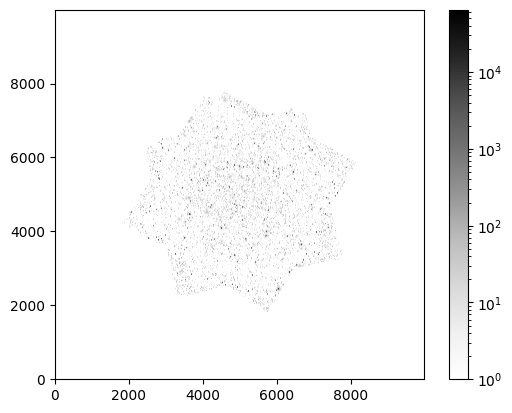

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


plt.figure()
plt.imshow(im_data, origin='lower', norm=LogNorm(), cmap='Greys')
plt.colorbar()
plt.show()


In [8]:
ff.info()

Filename: ngc6101/hlsp_hugs_hst_wfc3-uvis_ngc6101_f438w_v1_stack-0165s.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (10000, 10000)   float32   


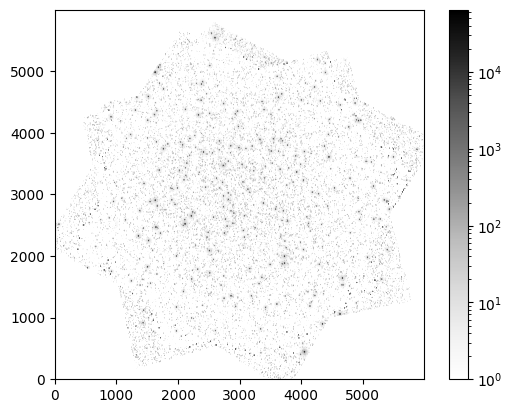

In [4]:
#section1 = im_data[2400:2600, 5650:5950]
#section1 = im_data[3000:3600, 5000:5600]
section1 = im_data[2000:8000, 2000:8000]

plt.figure()
plt.imshow(section1, origin='lower', norm=LogNorm(), cmap='Greys')
plt.colorbar()
plt.show()


In [3]:
from astropy.stats import sigma_clipped_stats 

mean, median, std = sigma_clipped_stats(section1, sigma= 3.0)
print(mean, median, std)

NameError: name 'section1' is not defined

In [4]:
from photutils.detection import DAOStarFinder

daofind = DAOStarFinder(fwhm=3.0, threshold=5.0*std)
sources1 = daofind(section1 - median)
for col in sources1.colnames:
    if col not in ('id', 'npix'):
        sources1[col].info.format = '%.2f'

#sources1.pprint(max_width = 76)

NameError: name 'std' is not defined

In [9]:
import numpy as np 
from photutils.aperture import CircularAperture

positions = np.transpose((sources1['xcentroid'], sources1['ycentroid']))
apertures = CircularAperture(positions, r=5.0)

'''
plt.imshow(section1, cmap='Greys', origin='lower', norm=LogNorm(), interpolation='nearest')
apertures.plot(color='red', lw=1.5, alpha=0.5);
'''

"\nplt.imshow(section1, cmap='Greys', origin='lower', norm=LogNorm(), interpolation='nearest')\napertures.plot(color='red', lw=1.5, alpha=0.5);\n"

In [10]:
print(apertures)

Aperture: CircularAperture
positions: [[3.63997709e+03, 1.05419831e+00],
            [3.64510194e+03, 5.62524883e-01],
            [3.51964645e+03, 1.47477603e+00],
            ...,
            [2.59193598e+03, 5.77844572e+03],
            [2.58305305e+03, 5.78468729e+03],
            [2.57320127e+03, 5.78774788e+03]]
r: 5.0


In [11]:
from photutils.aperture import CircularAnnulus, ApertureStats, aperture_photometry

annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)

'''
plt.imshow(section1, cmap='Greys', norm=LogNorm(), origin='lower', interpolation='nearest')
apertures.plot(color='red', lw=1.5, alpha=0.5);
annulus_aperture.plot(color='yellow', lw=1.5, alpha=0.3);
'''

"\nplt.imshow(section1, cmap='Greys', norm=LogNorm(), origin='lower', interpolation='nearest')\napertures.plot(color='red', lw=1.5, alpha=0.5);\nannulus_aperture.plot(color='yellow', lw=1.5, alpha=0.3);\n"

In [12]:
aper_stats = ApertureStats(section1, annulus_aperture)
bkg_mean = aper_stats.mean
aper_area = apertures.area_overlap(section1)
total_bkg = bkg_mean*aper_area
star_data = aperture_photometry(section1, apertures)

star_data['total_bkg'] = total_bkg
for col in star_data.colnames:
    star_data[col].info.format = '%.8g'

star_data.pprint()

  id   xcenter   ycenter   aperture_sum total_bkg
         pix       pix                           
----- --------- ---------- ------------ ---------
    1 3639.9771  1.0541983    228.86035 373.37222
    2 3645.1019 0.56252488    208.72836 1564.5665
    3 3519.6465   1.474776    5611.4796 35.203231
    4 3589.2421 0.28431335    53.034882  14.61127
    5 3689.7342 0.35744417   -16.986914 38.897816
    6 3779.0664  2.1494622    26.980773 25.728715
    7 3490.9421  2.9181452    20.530448 44.404966
    8 3744.7582  2.5175038   -17.353778  29.30801
    9 3836.8983  2.8323668     29.69826 178.16564
  ...       ...        ...          ...       ...
44139 2634.5529  5756.9894    73.796137 537.98775
44140 2601.0657  5760.5752    82.904472 359.43987
44141 2621.3377  5764.5161    141.12224 61.910212
44142 2556.3332  5767.5151    97.336388 60.507716
44143 2560.2097  5770.7601    72.457604 70.725906
44144  2598.514   5772.899    1557.3914 59.256383
44145 2558.7507  5777.8609    37.780323 63.312709


In [13]:
from acstools import acszpt

#date = 2006-05-31 , 14:42:25
#exposure time = 35s
#filter = F606W
#instrument: Hubble Space Telescope: ACS-WFC

date = '2006-05-31'
instrument = 'WFC'
filter = 'F435W'

q = acszpt.Query(date= date, detector = instrument)
zpt_table = q.fetch()
q_filter = acszpt.Query(date=date, detector=instrument,filt=filter)
filter_zpt=q_filter.fetch()

print(filter_zpt)
type(filter_zpt)

Filter PHOTLAM             PHOTFLAM            STmag  VEGAmag  ABmag 
       Angstrom erg / (Angstrom electron cm2) mag(ST)   mag   mag(AB)
------ -------- ----------------------------- ------- ------- -------
 F435W   4329.3                    3.1215e-19  25.164  25.789  25.674


astropy.table.table.QTable

In [14]:
import math
zeropoint = 25.674
exposure_time = 1800

magnitudes = []
for line in star_data:
    magnitudes.append(zeropoint-(2.4*math.log10(abs(line[3]-line[4])/exposure_time)))
star_data['magnitude'] = magnitudes

star_data.pprint(max_lines=-1, max_width=-1)

  id   xcenter    ycenter    aperture_sum  total_bkg      magnitude     
         pix        pix                                                 
----- ---------- ---------- ------------- ----------- ------------------
    1  3639.9771  1.0541983     228.86035   373.37222 28.302885563819153
    2  3645.1019 0.56252488     208.72836   1564.5665  25.96935518022075
    3  3519.6465   1.474776     5611.4796   35.203231  24.49542772510743
    4  3589.2421 0.28431335     53.034882    14.61127 29.683618334053072
    5  3689.7342 0.35744417    -16.986914   38.897816  29.29315042861231
    6  3779.0664  2.1494622     26.980773   25.728715  33.25235499137626
    7  3490.9421  2.9181452     20.530448   44.404966  30.17961092566208
    8  3744.7582  2.5175038    -17.353778    29.30801 29.481146705414154
    9  3836.8983  2.8323668      29.69826   178.16564  28.27473949061614
   10   3483.757  3.8533889    -3.6242687   35.798072 29.656872223462038
   11  3612.4185  5.4939588      286.0554   392.699

18.00104636849203	38.900291882207235	27.472588459326275	2.2744458950395616


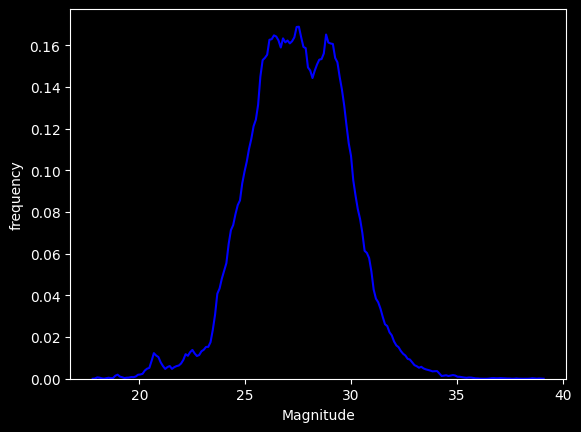

In [15]:
import seaborn as sns
import pandas as pd

mag_min = np.min(magnitudes)
mag_max = np.max(magnitudes)
mag_mid = np.mean(magnitudes)
mag_std = np.std(magnitudes)

print(f'{mag_min}\t{mag_max}\t{mag_mid}\t{mag_std}')

plt.style.use('dark_background')
mag_df = pd.DataFrame(magnitudes, columns=['Magnitude'])
fig, ax1 = plt.subplots()
ax1.set_ylabel('Density')
#sns.histplot(data=mag_df, x='Magnitude', binwidth=0.5, color='orange', ax=ax1)
#ax2 = ax1.twinx()

sns.kdeplot(data=mag_df, x='Magnitude', bw_adjust=0.25, color='blue', ax=ax1)
ax1.set_ylabel('frequency')
ax1.grid(False)
plt.show()


In [16]:
type(star_data)

astropy.table.table.QTable